## Code to save output of vh, uh and h along isopycnals for Southern Ocean

The theoretical framework for my project relies on data in density coordinates, rather than the depth coordinates that ACCESS-OM2 provides. In order to perform my analyses, I must bin these values into fixed density bins, and I do this via a binning process which saves the model output vh_rho_nt and uh_rho_nt and an interpolated version of dzu into each of these bins, across the Southern Ocean. I need to do this for 10 years, but currently run scripts in gadi for each month. Unfortunately their CPU usage is low - usually around 5% of 24 cores, while I need at least 80GB of memory. I am hence looking for assistance to parallelise the code so that the binning process is more resource efficient.

The binning process itself comes from https://journals.ametsoc.org/view/journals/phoc/37/5/jpo3057.1.xml

It involves choosing isopycnal bins on which to bin it, and then looping through the bins, assigning which two bin the model output is closest to in density and splitting the density between those two bins accordingly.

I have found binning a month of full Southern Ocean (35 to 70S) takes 2 hours, and I need to be able to do this for 10 years.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
#from gsw import SA_from_SP, p_from_z, sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Set up some parameters and open cluster.

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38137 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [ ]:
# #### get run count argument that was passed to python script #### (for PBS script)
# import sys
# run_count = int(sys.argv[1])


In [4]:
run_count = 3

In [5]:
if run_count<10:
    month = '0'+str(run_count)
elif run_count ==10:
    month = '10'
elif run_count ==11:
    month = '11'
elif run_count ==12:
    month = '12'
month

'03'

In [6]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

time_slice= year + '-' + month
start_time = year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
## FULL SO latitude range##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)



In [7]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 1.95 s, sys: 441 ms, total: 2.39 s
Wall time: 16.1 s


### Load quantities


Load daily vhrho, uhrho, dzt and density for the year chosen and select latitude/longitude region.

In [8]:
%%time

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
vhrho = cc.querying.getvar(expt,'vhrho_nt',session,start_time=start_time, end_time=end_time)
uhrho = cc.querying.getvar(expt,'uhrho_et',session,start_time=start_time, end_time=end_time)

# select latitude range and this month:
vhrho = vhrho.sel(yt_ocean=lat_range_big).sel(time=time_slice)
uhrho = uhrho.sel(yt_ocean=lat_range).sel(time=time_slice)


CPU times: user 4.42 s, sys: 448 ms, total: 4.87 s
Wall time: 10.7 s


Since vh_rho at northern edge of cell and uhrho at eastern edge, need to interpolate to tracer grid centre so that correct binning occurs, as density is in centre of t cell. Hence, interpolate uhrho in x direction and interpolate vhrho in y direction. uhrho is easy because it is periodic bouncaries. For vhrho, just include a latitude coordinate above and below and remove later.

### Load density and dzt

In [9]:
%%time

pot_rho_1 = cc.querying.getvar(expt,'pot_rho_1',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
pot_rho_1 = pot_rho_1.sel(yt_ocean=lat_range).sel(time=time_slice)
time = pot_rho_1.time


CPU times: user 1.26 s, sys: 162 ms, total: 1.42 s
Wall time: 1.86 s


In [10]:
%%time

dzt = cc.querying.getvar(expt,'dzt',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
dzt = dzt.sel(yt_ocean=lat_range_big).sel(time=time_slice)

CPU times: user 2.32 s, sys: 167 ms, total: 2.49 s
Wall time: 3.07 s


### Define density bins that I want the output to be binned into, and set up some zero arrays

In [11]:
## define isopycnal bins   - new as of 23 July
isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,
                                        32.3,32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])

In [12]:
## intialise empty transport along contour in density bins array
vh_binned = xr.DataArray(np.zeros((len(time),len(isopycnal_bins_sigma1),len(yt_ocean),len(xt_ocean))), 
                                               coords = [time,isopycnal_bins_sigma1, yt_ocean, xt_ocean], 
                                               dims = ['time','isopycnal_bins', 'yt_ocean','xt_ocean'], 
                                               name = 'vh_binned')
uh_binned = xr.DataArray(np.zeros((len(time),len(isopycnal_bins_sigma1),len(yt_ocean),len(xt_ocean))), 
                                               coords = [time,isopycnal_bins_sigma1, yt_ocean, xt_ocean], 
                                               dims = ['time','isopycnal_bins', 'yt_ocean','xt_ocean'], 
                                               name = 'uh_binned')
h_binned = xr.DataArray(np.zeros((len(time),len(isopycnal_bins_sigma1),len(yt_ocean),len(xt_ocean))), 
                                               coords = [time,isopycnal_bins_sigma1, yt_ocean, xt_ocean], 
                                               dims = ['time','isopycnal_bins', 'yt_ocean','xt_ocean'], 
                                               name = 'h_binned')


### loop over days to load daily data then bin using bin_mask into nearest isopycnal, weighted by which isopycnal the cell is closest to.

Note: if time is not looped over, then nothing happens - it just stalls.

And I'm not sure how to do the binning process without a loop. The two loops, and assigning values to arrays via [day, i+1,:,:], are I think what is slowing it down and removing xarray/dask functionality.

In [ ]:
%%time
for day in range(3): #should be range(len(time)) but this is for time test (submit as a PBS script to gadi)
    print('day '+str(day))
    uhrho_j = uhrho[day,...]
    uhrho_j = uhrho_j.fillna(0)
    uhrho_j = uhrho_j.load()
    vhrho_j = vhrho[day,...]
    vhrho_j = vhrho_j.fillna(0)
    vhrho_j = vhrho_j.load()
    
    #move uhrho and vhrho to t grid since uhrho is eastern side of cell and vhrho on northern
    uhrho_t = 0.5*(uhrho_j+uhrho_j.roll(xt_ocean=1, roll_coords = False)) #this takes average of adjacent cells
    
    vhrho_t = 0.5*(vhrho_j+vhrho_j.roll(yt_ocean=1, roll_coords = False))
    vhrho_t = vhrho_t[:,1:-1,:] # remove the outside values as their roll is incorrect
    #load dzt and pot_rho_1 
    dzt_j = dzt[day,...]
    dzt_j = dzt_j.fillna(0)
    dzt_j = dzt_j.load()
    
    #vhrho and uhrho grids are from BAY(dzu) and BAX(dzu) NOT dzt: find these
    dzt_j_right = dzt_j.roll(xt_ocean = -1, roll_coords = False)
    dzt_j_up = dzt_j.roll(yt_ocean = -1,roll_coords = False)
    dzt_j_up_right=dzt_j.roll(yt_ocean = -1,roll_coords = False).roll(xt_ocean = -1, roll_coords = False)
    dzu = np.fmin(np.fmin(np.fmin(dzt_j,dzt_j_right),dzt_j_up),dzt_j_up_right)
    #now the xgrid needs BAY(dzu) while ygrid needs BAX(dzu) so that they are on uhrho and vhrho grids. we only need to do one,
    #as they are equivalent when interpolatred to t-grid. I chose to find BAX because I took dzt to have bigger lon range
    dzu_e = dzu.copy()
    dzu_w = dzu.roll(xt_ocean = 1, roll_coords=False)
    BAX_dzu = (dzu_w+dzu_e)/2    
    
    #as with vhrho these need to be moved to t-grid in the same way:
    dzt_j = 0.5*(BAX_dzu+BAX_dzu.roll(yt_ocean=1, roll_coords = False))
    dzt_j = dzt_j[:,1:-1,:]

    pot_rho_1_j = pot_rho_1[day,...]
    pot_rho_1_j = pot_rho_1_j.fillna(0)
    pot_rho_1_j = pot_rho_1_j.load()

    print('succesfully loaded! now binning')
    
    for i in range(len(isopycnal_bins_sigma1)-1):
        print(i)
        #create masks for isopycnal binnning, that are 1 where the density that day is between two bin values, and 0 elsewhere
        bin_mask = pot_rho_1_j.where(pot_rho_1_j<=isopycnal_bins_sigma1[i+1]).where(pot_rho_1_j>isopycnal_bins_sigma1[i])*0+1
        # create a fractional value that splits the transport between each bin based on which bin it is closer to
        bin_fractions = (isopycnal_bins_sigma1[i+1]-pot_rho_1_j * bin_mask)/(isopycnal_bins_sigma1[i+1]-isopycnal_bins_sigma1[i])
        
        ## vh - splits transport between the two bins and saves into vh_binned array
        transport_across_contour_in_sigmalower_bin = ( vhrho_t * bin_mask * bin_fractions).sum(dim = 'st_ocean')
        vh_binned[day,i,:,:] += transport_across_contour_in_sigmalower_bin.fillna(0)
        del transport_across_contour_in_sigmalower_bin
        transport_across_contour_in_sigmaupper_bin = ( vhrho_t * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
        vh_binned[day,i+1,:,:] += transport_across_contour_in_sigmaupper_bin.fillna(0)
        del transport_across_contour_in_sigmaupper_bin
        
        ## uh
        transport_across_contour_in_sigmalower_bin = ( uhrho_t * bin_mask * bin_fractions).sum(dim = 'st_ocean')
        uh_binned[day,i,:,:] += transport_across_contour_in_sigmalower_bin.fillna(0)
        del transport_across_contour_in_sigmalower_bin
        transport_across_contour_in_sigmaupper_bin = ( uhrho_t * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
        uh_binned[day,i+1,:,:] += transport_across_contour_in_sigmaupper_bin.fillna(0)
        del transport_across_contour_in_sigmaupper_bin
        
        ## h
        transport_across_contour_in_sigmalower_bin = (dzt_j * bin_mask * bin_fractions).sum(dim = 'st_ocean')
        h_binned[day,i,:,:] += transport_across_contour_in_sigmalower_bin.fillna(0)
        del transport_across_contour_in_sigmalower_bin
        transport_across_contour_in_sigmaupper_bin = (dzt_j * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
        h_binned[day,i+1,:,:] += transport_across_contour_in_sigmaupper_bin.fillna(0)
        del bin_mask, bin_fractions, transport_across_contour_in_sigmaupper_bin
        
    del pot_rho_1_j, dzt_j, uhrho_j, vhrho_j, uhrho_t, vhrho_t, dzt_j_right,dzt_j_up, dzt_j_up_right, BAX_dzu, dzu_e, dzu_w

print('wow, done! have a nice day')

day 0
succesfully loaded! now binning
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
day 1
succesfully loaded! now binning
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
day 2
succesfully loaded! now binning
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


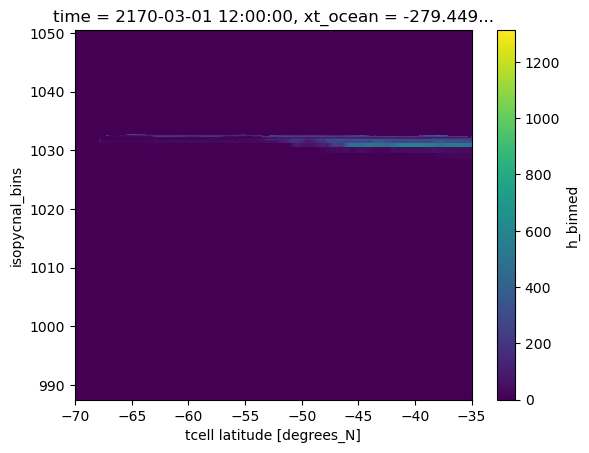

In [19]:
h_binned.isel(time = 0).isel(xt_ocean=5).plot()

#### 12 mins for 3 days = 4 mins each day -> 1 month should take approx 2 hours.